In [2]:
import pandas as pd
import numpy as np
import sklearn.base
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBClassifier
import imblearn
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn import svm
import hyperopt
import matplotlib.pyplot as plt

In [3]:
#задание количества выводимых на экран строк
pd.options.display.max_rows = 96
#создание датафрейма
df = pd.read_csv("data.csv")
#print(df.dtypes)

In [4]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

In [4]:
print((df.loc[:,'Bankrupt?'] == 1).sum())
print((df.loc[:,'Bankrupt?'] == 0).sum())
#выравниваем вклад в функцию потерь позитивных и негативных данных
scale_pos_weight = (df.loc[:,'Bankrupt?'] == 0).sum()/(df.loc[:,'Bankrupt?'] == 1).sum()
print(scale_pos_weight)

220
6599
29.995454545454546


In [5]:
#Создали класс, реализующий ансамль LogisticRegression-моделей, обученных на случайных сбалансированных подвыборках
class ResampledEnsembleSVM(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, ensemble_quantile = 0.5, column_probability = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        #добавляем вместо среднего арифметического квантиль
        self.ensemble_quantile = ensemble_quantile
        #Добавили рандомизацию по колонкам признака
        self.column_probability = column_probability

    def fit(self, X, y):
        self.estimators = []
        self.estimators_columns = []
        for i in range(self.n_estimators):
            #хранит индикатор того будет ли использоваться столбец данных
            outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            while outcome.sum() == 0: #индикатор того, что ни один столбец не выбран
                outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            columns = np.where(outcome == 1)[0]
            self.estimators_columns.append(columns)
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])
            # print(final_indexes)
            # print(X[final_indexes, columns])
            model = svm.SVC(class_weight = {0: 1, 1: self.scale_pos_weight})
            #model.fit(X[final_indexes, :], y[final_indexes])
            model.fit(X[np.ix_(final_indexes, columns)], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")

    # def predict_proba(self, X):
    #     results = np.zeros([self.n_estimators, X.shape[0], 2]) #количество строк в иксе, количество столбцов по числу классов [0] и [1]
    #     for i in range(self.n_estimators):
    #         results[i,:,:] = self.estimators[i].predict_proba(X[:, self.estimators_columns[i]])
    #     if self.ensemble_quantile is None:
    #         ensemble_results = np.mean(results**self.power, axis = 0)
    #     else:
    #         ensemble_results = np.quantile(results**self.power, self.ensemble_quantile, axis = 0)
    #     row_sums =  np.sum(ensemble_results, axis = 1)
    #     return ensemble_results/row_sums[:, None]

    def predict(self, X):
        results = np.zeros([self.n_estimators, X.shape[0]])
        for i in range(self.n_estimators):
            results[i,:] = self.estimators[i].predict(X[:, self.estimators_columns[i]])
        res_classes = (results.sum(axis = 0) >= results.shape[0]*self.ensemble_quantile).astype(int)
        return res_classes

In [6]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsembleSVM()
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
#print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [1 1 1 1 0]


In [64]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsembleSVM(ensemble_quantile = 0.6, column_probability = 0.01)
cv = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 2.121 (1.492)
score_time: 3.850 (1.323)
test_accuracy: 0.962 (0.009)
test_precision: 0.390 (0.088)
test_recall: 0.343 (0.179)
test_f1: 0.339 (0.108)


При column_probability = 0.01, scale_pos_weight = 0.9
test_accuracy: 0.965 (0.006)
test_precision: 0.442 (0.074)
test_recall: 0.265 (0.100)

При ensemble_quantile = 0.6, column_probability = 0.01:
test_accuracy: 0.956 (0.009)
test_precision: 0.368 (0.079)
test_recall: 0.383 (0.158)
test_f1: 0.347 (0.053)


In [8]:
A = np.array([[1,1,1],[1,0,1],[0,0,0]]) #А - пример вывода субмоделей (подмоделей) из ансамбля
#по столбцам идут разные элементы выборки, а сами значения столбцов - соответствующее выходное значение. 3 строки означает, что n_estimators = 3.
(A.sum(axis = 0) >= A.shape[0]/2).astype(int)

array([1, 0, 1])

In [9]:
#Создали класс, реализующий ансамль XGB-моделей, обученных на случайных сбалансированных подвыборках с ансамблирующей функцией в виде модели машинного обучения
class SmartResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, column_probability = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        self.column_probability = column_probability

    def fit(self, X, y):
        self.estimators = []
        self.estimators_columns = []
        for i in range(self.n_estimators):
            #хранит индикатор того будет ли использоваться столбец данных
            outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            while outcome.sum() == 0: #индикатор того, что ни один столбец не выбран
                outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            columns = np.where(outcome == 1)[0]
            self.estimators_columns.append(columns)
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])

            model = svm.SVC(class_weight = {0: 1, 1: self.scale_pos_weight})

            model.fit(X[np.ix_(final_indexes, columns)], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict(X[:, self.estimators_columns[i]])
        self.ensemblingmodel = XGBClassifier()
        self.ensemblingmodel.fit(results, y)


    def predict(self, X):
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict(X[:, self.estimators_columns[i]])
        res_classes = self.ensemblingmodel.predict(results)
        return res_classes

In [10]:
#XGBClassifier() - ансамблирующая модель
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble()
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))

Predicted classes: [0 1 0 0 1]


In [12]:
#XGBClassifier() - ансамблирующая модель
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:, 'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(zeros_ratio = 2, column_probability = 0.05)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=cv, n_jobs=4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 36.583 (26.259)
score_time: 5.326 (1.020)
test_accuracy: 0.965 (0.004)
test_precision: 0.419 (0.047)
test_recall: 0.230 (0.044)
test_f1: 0.296 (0.043)


In [13]:
#Создали класс, реализующий ансамль XGB-моделей, обученных на случайных сбалансированных подвыборках с ансамблирующей функцией в виде модели машинного обучения
class SmartResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, column_probability = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        self.column_probability = column_probability

    def fit(self, X, y):
        self.estimators = []
        self.estimators_columns = []
        for i in range(self.n_estimators):
            #хранит индикатор того будет ли использоваться столбец данных
            outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            while outcome.sum() == 0: #индикатор того, что ни один столбец не выбран
                outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            columns = np.where(outcome == 1)[0]
            self.estimators_columns.append(columns)
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])

            model = svm.SVC(class_weight = {0: 1, 1: self.scale_pos_weight})

            model.fit(X[np.ix_(final_indexes, columns)], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict(X[:, self.estimators_columns[i]])
        self.ensemblingmodel = sklearn.tree.DecisionTreeClassifier()
        self.ensemblingmodel.fit(results, y)


    def predict(self, X):
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict(X[:, self.estimators_columns[i]])
        res_classes = self.ensemblingmodel.predict(results)
        return res_classes

In [15]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))

Predicted classes: [0 0 0 0 0]


In [16]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble()
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 80.212 (10.723)
score_time: 20.385 (3.694)
test_accuracy: 0.942 (0.006)
test_precision: 0.058 (0.037)
test_recall: 0.050 (0.032)
test_f1: 0.053 (0.034)


In [16]:
#hyperopt
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

def hyperopt_train_test(params):
    clf = ResampledEnsembleSVM(n_estimators = 100, **params)
    return sklearn.model_selection.cross_val_score(clf, X, y, scoring = "f1").mean()

params_space = {
    'zeros_ratio': hyperopt.hp.lognormal('zeros_ratio', 0, 1),
    'scale_pos_weight': hyperopt.hp.lognormal('scale_pos_weight', 0, 1),
    'ensemble_quantile': hyperopt.hp.uniform('ensemble_quantile', 0, 1),
    'column_probability': hyperopt.hp.uniform('column_probability', 0, 0.1),

}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

trials = hyperopt.Trials() #объект для сбора информации об ошибках
best = hyperopt.fmin(f, params_space, algo = hyperopt.tpe.suggest, max_evals = 30, trials = trials)
print(best)

 67%|██████▋   | 20/30 [09:05<05:56, 35.65s/trial, best loss: -0.26528932653619763]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_11560\2699103946.py", line 27, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

 77%|███████▋  | 23/30 [09:07<01:52, 16.05s/trial, best loss: -0.26528932653619763]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_11560\2699103946.py", line 27, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

 87%|████████▋ | 26/30 [09:16<00:40, 10.19s/trial, best loss: -0.26528932653619763]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_11560\2699103946.py", line 27, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

100%|██████████| 30/30 [10:00<00:00, 20.03s/trial, best loss: -0.26528932653619763]
{'column_probability': 0.04442839844302744, 'ensemble_quantile': 0.9895478960413301, 'scale_pos_weight': 0.4621489719475659, 'zeros_ratio': 0.32011010776657195}


C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_11560\2699103946.py", line 27, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

In [17]:
def plot_trials(trials, param):
    f, ax = plt.subplots(1)
    xs = [t["tid"] for t in trials.trials]
    ys = [t['misc']['vals'][param] for t in trials.trials]
    zs = np.array([-t["result"]['loss'] for t in trials.trials])

    image = ax.scatter(xs, ys, c = zs, s = 100*zs+5, linewidth = 2 , alpha = 1)
    ax.set_xlabel('iteration', fontsize = 8)
    ax.set_ylabel(param, fontsize = 8)
    f.colorbar(image)

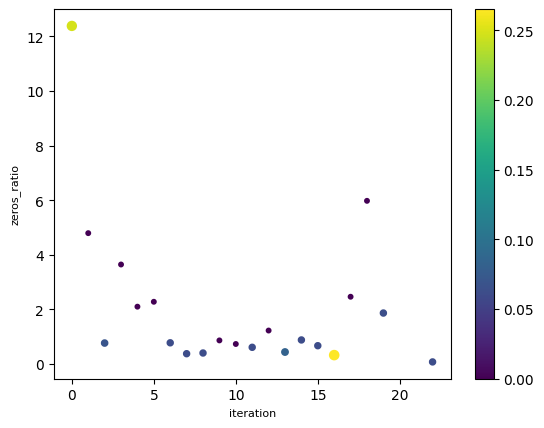

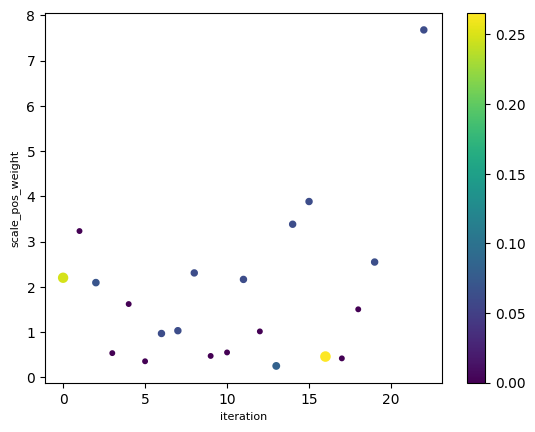

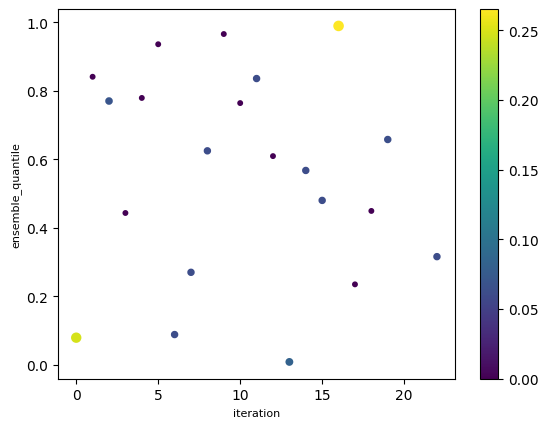

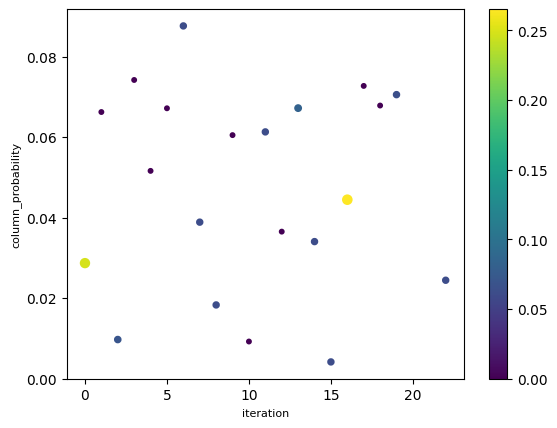

In [18]:
for params in params_space:
    plot_trials(trials, params)